<center>
    # How to become a correlation wizard with the brightwind library!
</center>

***

In [1]:
import datetime
print('Last updated: {}'.format(datetime.date.today().strftime('%d %B, %Y')))

Last updated: 27 June, 2019


***
## Outline:

This guide will demonstrate how to do some useful correlations with a sample site dataset and 4 separate reference datasets using the following steps:

- Import the brightwind library and some sample raw data and clean it
- Import 4 sample reference datasets to use in the correlation
- Perform a ordinary least squares correlation for 1 dataset and time period
- Perform a ordinary least squares correlation for multiple datasets and time periods


***

In [2]:
import brightwind as bw

In [3]:
# specify location of existing sample dataset
filepath = r'C:\...\brightwind\datasets\demo\demo_data.csv'
# load data as dataframe
data = bw.load_csv(filepath)
# specify location of existing cleaning file
Cleaning_Filepath = r'C:\...\brightwind\datasets\demo\demo_cleaning_file.csv'
# Apply cleaning file to Raw Data
data = bw.apply_cleaning(data,Cleaning_Filepath)
# show first few rows of dataframe
data.head(5)

Cleaning applied. (Please remember to assign the cleaned returned DataFrame to a variable.)


,Spd80mN,Spd80mS,Spd60mN,Spd60mS,Spd40mN,Spd40mS,Spd80mNStd,Spd80mSStd,Spd60mNStd,Spd60mSStd,...,Dir78mSStd,Dir58mS,Dir58mSStd,Dir38mS,Dir38mSStd,T2m,RH2m,P2m,PrcpTot,BattMin
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-09 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09 17:10:00,7.382,7.325,6.818,6.689,6.252,6.174,0.844,0.810,0.897,0.875,...,4.680,118.8,5.107,115.6,5.189,0.954,100.0,934.0,0.0,12.71
2016-01-09 17:20:00,7.977,7.791,8.110,7.915,8.140,7.974,0.556,0.528,0.562,0.524,...,3.123,115.9,2.960,113.6,3.540,0.863,100.0,934.0,0.0,12.69


### Lets import some reference datasets

For this example, we will import 4 MERRA-2 reanalysis datasets. These can be found as sample datasets within the brightwind library. We use the `load_csv()` function to load in each dataset from a csv file. We then assign each of the datasets to a python dictionary, so we can easily loop through them later.

In [4]:
Merra2_NE =  bw.load_csv(r'C:\...\brightwind\datasets\demo\MERRA-2_NE_2000-01-01_2017-06-30.csv')
Merra2_NW =  bw.load_csv(r'C:\...\brightwind\datasets\demo\MERRA-2_NW_2000-01-01_2017-06-30.csv')
Merra2_SE =  bw.load_csv(r'C:\...\brightwind\datasets\demo\MERRA-2_SE_2000-01-01_2017-06-30.csv')
Merra2_SW =  bw.load_csv(r'C:\...\brightwind\datasets\demo\MERRA-2_SW_2000-01-01_2017-06-30.csv')

Merra2 = {'M2_NE':Merra2_NE,'M2_NW':Merra2_NW,'M2_SE':Merra2_SE,'M2_SW':Merra2_SW}

### Ordinary Least Squares Regression

Here we look at performing a basic linear regression correlation using the Ordinary Least Squares method between the 80m north facing site anemometer and the MERRA-2 dataset located to the North East (M2_NE). We then use the averaging_prd variable to set the time period for which the correlation should be carried out. This can be hourly or multiples of hour (1H,2H,3H,etc), daily or multiples of days (1D,2D,3D,15D,etc), monthly (1M) or yearly (1AS). Here we select a 15 day correlation. Finally we set the coverage threshold, this is the minimum coverage of data during each averaging period from both the reference and site dataset that will be permitted to be used in the correlation. In this case we use a coverage threshold of 90%. The correlation function returns a python object. This has to be subsequently run using the `run()` function and plotted using the `plot()` function.

{'Num data points': 34,
 'offset': -0.3469504509964136,
 'r2': 0.9580669877674568,
 'slope': 1.0312563688477243}


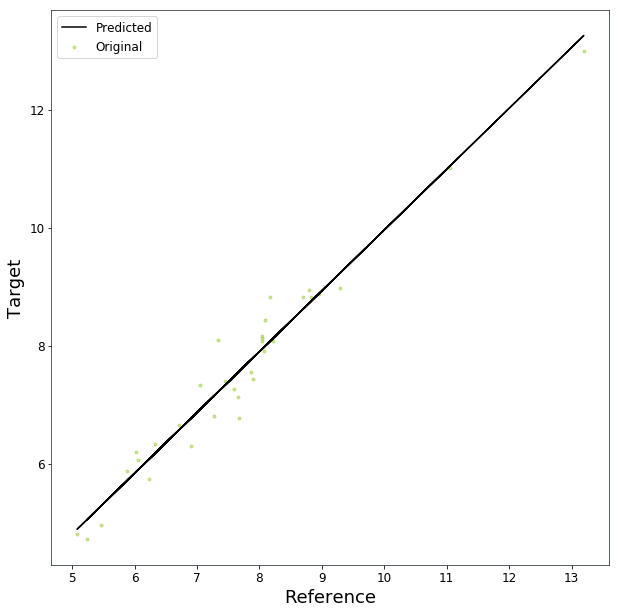

In [5]:
obj = bw.Correl.OrdinaryLeastSquares(Merra2['M2_NE']['WS50m_m/s'], data['Spd80mN'], averaging_prd='15D', coverage_threshold=0.90)
obj.run()
obj.plot()

What we have done is good for performing one correlation with specific parameters. But normally we would like to run this for multiple reference datasets and multiple averaging periods. The code below performs two for loops to iterate through each of the MERRA-2 datasets and each time period specified, and returns the results in a dataframe. In order to specify the results as a dataframe, we need to first import the pandas library.

In [6]:
import pandas as pd

In [7]:
correl_result_80m = pd.DataFrame()
for node in Merra2:
    for i in ['1D','3D','7D','15D','1M']:
        obj = bw.Correl.OrdinaryLeastSquares(Merra2[node]['WS50m_m/s'], data['Spd80mN'], averaging_prd=i, coverage_threshold=0.90)
        obj.run()
        obj.params['Number of points'] = obj.num_data_pts
        obj.params['LT Target Windspeed'] = bw.momm(obj.synthesize())
        obj.params['Adjustment_perc'] = -(1-(obj.params['LT Target Windspeed']/data['Spd80mN'].mean()))*100
        obj.params['Site MOMM'] = bw.momm(data['Spd80mN'])
        obj.params['LT Reference'] = bw.momm(Merra2[node]['WS50m_m/s'])
        obj.params['Averaging Period'] = i
        obj.params['Reanalysis dataset'] = node
        correl_result_80m = pd.concat([correl_result_80m,pd.DataFrame.from_records(obj.params, index=[0])], axis=0)
         


{'Num data points': 509,
 'offset': -0.4248784474400295,
 'r2': 0.8950111609239269,
 'slope': 1.040347744890449}
{'Num data points': 166,
 'offset': -0.6361907996697529,
 'r2': 0.934717237380914,
 'slope': 1.065506067469903}
{'Num data points': 71,
 'offset': -0.5882020865023719,
 'r2': 0.9340706234081555,
 'slope': 1.0608473791176414}
{'Num data points': 34,
 'offset': -0.3469504509964136,
 'r2': 0.9580669877674568,
 'slope': 1.0312563688477243}
{'Num data points': 16,
 'offset': -0.06161432045219376,
 'r2': 0.9407857754972966,
 'slope': 0.9955561116923611}
{'Num data points': 509,
 'offset': -0.09566950948358079,
 'r2': 0.8467424753668483,
 'slope': 0.9513356833362564}
{'Num data points': 166,
 'offset': -0.3094075956208962,
 'r2': 0.8958363060049799,
 'slope': 0.9763981012985756}
{'Num data points': 71,
 'offset': -0.2654084062536,
 'r2': 0.890799351069137,
 'slope': 0.9719866140592955}
{'Num data points': 34,
 'offset': 0.15682108376560136,
 'r2': 0.9206266548035889,
 'slope': 0.92

The outputted results above are the result of the `obj.run()` function. We have saved a dataframe with a summary of the resultsunder correl_result_80m , so lets take a look at that now.

In [8]:
correl_result_80m

,Adjustment_perc,Averaging Period,LT Reference,LT Target Windspeed,Num data points,Number of points,Reanalysis dataset,Site MOMM,offset,r2,slope
0,1.095465,1D,7.707068,7.601000,509,509,M2_NE,7.575777,-0.424878,0.895011,1.040348
0,0.773044,3D,7.707068,7.576759,166,166,M2_NE,7.575777,-0.636191,0.934717,1.065506
0,1.031245,7D,7.707068,7.596172,71,71,M2_NE,7.575777,-0.588202,0.934071,1.060847
0,1.087716,15D,7.707068,7.600418,34,34,M2_NE,7.575777,-0.346950,0.958067,1.031256
0,1.400269,1M,7.707068,7.623917,16,16,M2_NE,7.575777,-0.061614,0.940786,0.995556
0,1.492676,1D,8.114629,7.630865,509,509,M2_NW,7.575777,-0.095670,0.846742,0.951336
0,1.245460,3D,8.114629,7.612278,166,166,M2_NW,7.575777,-0.309408,0.895836,0.976398
0,1.471205,7D,8.114629,7.629251,71,71,M2_NW,7.575777,-0.265408,0.890799,0.971987
0,1.408951,15D,8.114629,7.624570,34,34,M2_NW,7.575777,0.156821,0.920627,0.920225
0,1.663650,1M,8.114629,7.643720,16,16,M2_NW,7.575777,0.645332,0.877242,0.860974


We can easily scan down through the results to see the $r^2$ results of interest for different averaging periods and different datasets, and see other key metrics such as the predicted long term wind speed and the percentage adjustment from the measured site wind speed to the long term wind speed. This shows the power of how easy the library makes it to compare large numbers of reference datasets and get back useful results fast! Upcoming updates to the library will aim to reduce the code required to perform the looping procedure, so watch this space!

***

The library also includes a host of other correlation functions such as:

- `OrthogonalLeastSquares()`
- `MultipleLinearRegression()`
- `Speedsort()`
- `SVR()`


The `OrthogonalLeastSquares()` function carries out a orthogonal least squares regression correlation. 

The `MultipleLinearRegression()` function allows linear regression to be carried out between multiple reference datasets and the site data.

The `Speedsort()` function is a directional correlation method developed by Brian Hurley and Ciaran King as outlined in the paper "The Speedsort, DynaSort and Scatter wind correlation methods", Wind Engineering Volume 29, No.3, pp 217-241.

The `SVR()` function is a support vector machine correlation method which is a wrapper around the Scikit-learn python library.

These functions will be the subject of future tutorials relating to correlation methods.